# Metropolis sampling

In this notebook we analyse the results from VMC calculations on a spherical harmonic oscillator using brute force Metropolis.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tqdm

from vmc.interface import PyHarmonicOscillator, PyMetropolisAlgorithm, \
    PySimpleGaussian, PySimpleGaussianNumerical, PySampler, \
    PyImportanceMetropolis

from IPython.core.pylabtools import figsize

In [2]:
sns.set(color_codes=True)
figsize(14, 10)

We use natural units with $m = \hbar = c = 1$. We also restrict our views to $\omega = 1$ in this analysis.

In [3]:
mass = 1.0
omega = 1.0
hbar = 1.0

In [4]:
spread = 5.0
step_length = 1.0

## The one dimensional spherical harmonic oscillator

Starting with the simplest case we look at the one dimensional spherical harmonic oscillator.

\begin{align}
    \Psi_T(\mathbf{x}) &= \prod_{i = 1}^N\exp(-\alpha x_i).
\end{align}

We wish to compare the CPU time of the analytical scheme, i.e., an analytical expression for the Laplcian and hence the local energy, versus a central difference scheme of second order.

We know that the exact ground state energy for the one dimensional spherical harmonic oscillator can be found at $\alpha = 0.5$. By restricting our view to the region $\alpha \in [0.1, 0.7]$ we should observe a trend where the average energy goes towards a minimum at $\alpha = 0.5$ and increases on both sides.

In [5]:
alpha_min = 0.3
alpha_max = 0.7
num_alphas = 15

alphas = np.linspace(alpha_min, alpha_max, num_alphas).reshape(num_alphas, 1)

In [6]:
num_particles = 1
num_dimensions = 3

#num_samples = int(num_particles * 12000)
num_samples = int(1e6)
num_thermalization_steps = int(num_particles * 2000)

In [7]:
num_local_energies = 0

In [8]:
solver_analytical = PyMetropolisAlgorithm(num_particles)
#solver = PyImportanceMetropolis(num_particles)
wavefunction_analytical = PySimpleGaussian(
    num_particles, num_dimensions, mass, omega, spread=spread)
hamiltonian_analytical = PyHarmonicOscillator()
sampler_analytical = PySampler(
    wavefunction_analytical, hamiltonian_analytical, solver_analytical, num_local_energies)

In [9]:
solver_approximate = PyMetropolisAlgorithm(num_particles)
wavefunction_approximate = PySimpleGaussianNumerical(
    num_particles, num_dimensions, mass, omega, h=1e-8, spread=spread)
hamiltonian_approximate = PyHarmonicOscillator()
sampler_approximate = PySampler(
    wavefunction_approximate, hamiltonian_approximate, solver_approximate, num_local_energies)

In [10]:
energies_analytical = np.zeros(num_alphas)
variance_analytical = np.zeros(num_alphas)
energies_approximate = np.zeros(num_alphas)
variance_approximate = np.zeros(num_alphas)
num_experiments = 2

for experiment in tqdm.tqdm(range(num_experiments)):
    for i in range(num_alphas):
        wavefunction_analytical.set_parameters(alphas[i])
        wavefunction_approximate.set_parameters(alphas[i])

        sampler_analytical.sample(num_samples, step_length, num_thermalization_steps=num_thermalization_steps)
        sampler_approximate.sample(num_samples, step_length, num_thermalization_steps)

        energies_analytical[i] += sampler_analytical.get_energy()
        variance_analytical[i] += sampler_analytical.get_variance()

        energies_approximate[i] += sampler_approximate.get_energy()
        variance_approximate[i] += sampler_approximate.get_variance()

        wavefunction_analytical.redistribute()
        wavefunction_approximate.redistribute()

energies_analytical /= num_experiments
variance_analytical /= num_experiments
energies_approximate /= num_experiments
variance_approximate /= num_experiments

100%|██████████| 2/2 [00:17<00:00,  8.53s/it]


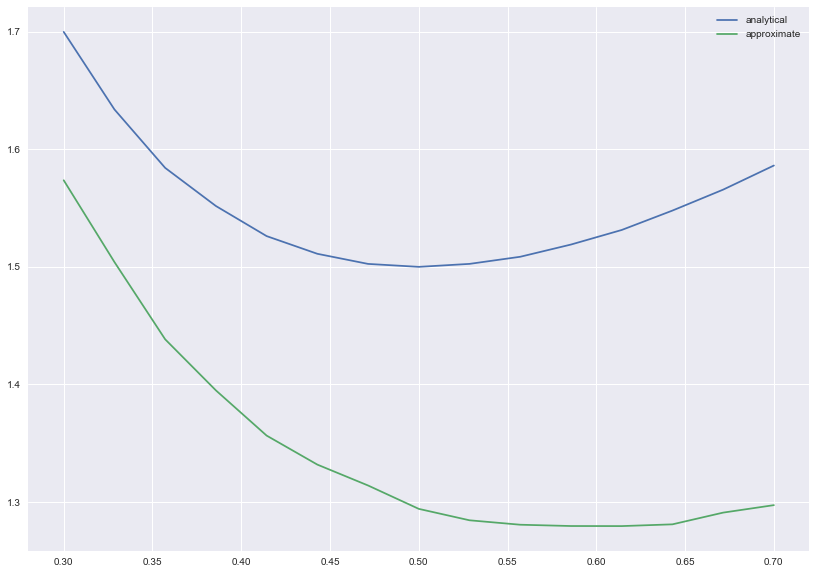

In [11]:
plt.plot(alphas.ravel(), energies_analytical, label="analytical")
plt.plot(alphas.ravel(), energies_approximate, label="approximate")
plt.legend(loc="best")
plt.show()

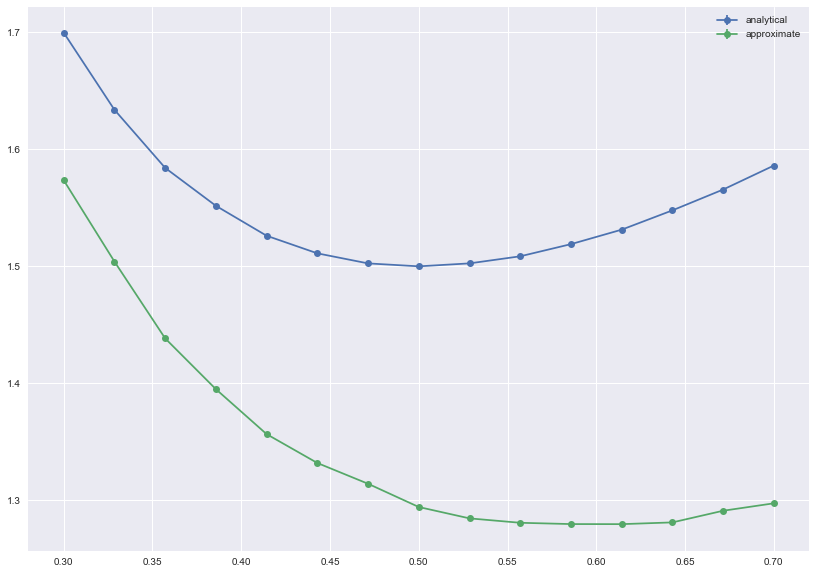

In [12]:
plt.errorbar(
    alphas.ravel(), energies_analytical, yerr=np.sqrt(variance_analytical)/np.sqrt(num_samples),
    label="analytical", fmt="o-")
plt.errorbar(
    alphas.ravel(), energies_approximate, yerr=np.sqrt(variance_approximate)/np.sqrt(num_samples),
    label="approximate", fmt="o-")
plt.legend(loc="best")
plt.show()

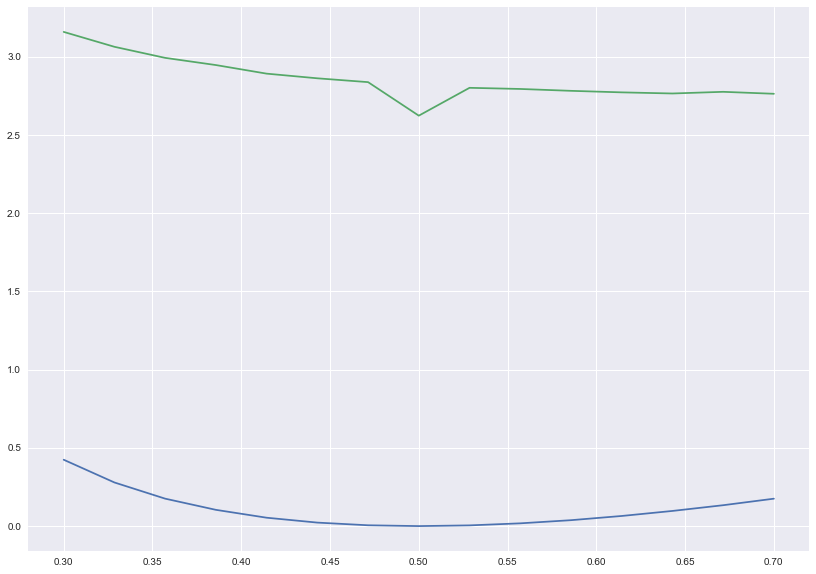

In [13]:
plt.plot(alphas.ravel(), variance_analytical/num_particles)
plt.plot(alphas.ravel(), variance_approximate/num_particles)
plt.show()

In [14]:
for alpha, energy, variance in zip(alphas, energies_analytical, variance_analytical):
    print ("Alpha: {0:8.8f} Energy: {1:8.8f} Variance: {2:8.8f}".format(
        alpha[0], energy/num_particles/num_dimensions, variance/num_particles/num_dimensions))

Alpha: 0.30000000 Energy: 0.56657274 Variance: 0.14140029
Alpha: 0.32857143 Energy: 0.54460641 Variance: 0.09295111
Alpha: 0.35714286 Energy: 0.52804777 Variance: 0.05846108
Alpha: 0.38571429 Energy: 0.51724500 Variance: 0.03463461
Alpha: 0.41428571 Energy: 0.50871629 Variance: 0.01786272
Alpha: 0.44285714 Energy: 0.50370209 Variance: 0.00744456
Alpha: 0.47142857 Energy: 0.50083511 Variance: 0.00174018
Alpha: 0.50000000 Energy: 0.50000000 Variance: 0.00000000
Alpha: 0.52857143 Energy: 0.50084234 Variance: 0.00153610
Alpha: 0.55714286 Energy: 0.50286027 Variance: 0.00588165
Alpha: 0.58571429 Energy: 0.50632337 Variance: 0.01259226
Alpha: 0.61428571 Energy: 0.51044883 Variance: 0.02156194
Alpha: 0.64285714 Energy: 0.51594846 Variance: 0.03229089
Alpha: 0.67142857 Energy: 0.52188231 Variance: 0.04449821
Alpha: 0.70000000 Energy: 0.52871532 Variance: 0.05841507


In [15]:
for alpha, energy, variance in zip(alphas, energies_approximate, variance_approximate):
    print ("Alpha: {0:8.8f} Energy: {1:8.8f} Variance: {2:8.8f}".format(
        alpha[0], energy/num_particles/num_dimensions, variance/num_particles/num_dimensions))

Alpha: 0.30000000 Energy: 0.52453581 Variance: 1.05313781
Alpha: 0.32857143 Energy: 0.50136611 Variance: 1.02140827
Alpha: 0.35714286 Energy: 0.47947147 Variance: 0.99781050
Alpha: 0.38571429 Energy: 0.46500269 Variance: 0.98249973
Alpha: 0.41428571 Energy: 0.45219103 Variance: 0.96420289
Alpha: 0.44285714 Energy: 0.44396878 Variance: 0.95427124
Alpha: 0.47142857 Energy: 0.43804932 Variance: 0.94610796
Alpha: 0.50000000 Energy: 0.43142402 Variance: 0.87465494
Alpha: 0.52857143 Energy: 0.42818809 Variance: 0.93398849
Alpha: 0.55714286 Energy: 0.42693347 Variance: 0.93155437
Alpha: 0.58571429 Energy: 0.42656558 Variance: 0.92756768
Alpha: 0.61428571 Energy: 0.42654538 Variance: 0.92430734
Alpha: 0.64285714 Energy: 0.42704228 Variance: 0.92190801
Alpha: 0.67142857 Energy: 0.43036504 Variance: 0.92546636
Alpha: 0.70000000 Energy: 0.43248210 Variance: 0.92128406


In [16]:
print ("Ratio for analytical solution: {0:.5f}".format(
    sampler_analytical.get_ratio_of_accepted_steps()))
print ("Ratio for numerical solution: {0:.5f}".format(
    sampler_approximate.get_ratio_of_accepted_steps()))

Ratio for analytical solution: 0.43335
Ratio for numerical solution: 0.43337


In [17]:
def exact_energy(alpha, omega, mass, num_particles, num_dimensions):
    first_term = hbar**2*num_dimensions*alpha*num_particles/float(mass)
    second_term = 0.5*mass*omega**2*num_particles*(1.0/(4.0*alpha))*num_dimensions
    third_term = -2*hbar**2*alpha**2*num_particles/float(mass)*(1.0/(4.0*alpha))*num_dimensions

    return first_term + second_term + third_term

In [18]:
energy_exact = np.zeros(num_alphas)

for i in range(num_alphas):
    energy_exact[i] = exact_energy(alphas[i, 0], omega, mass, num_particles, num_dimensions)

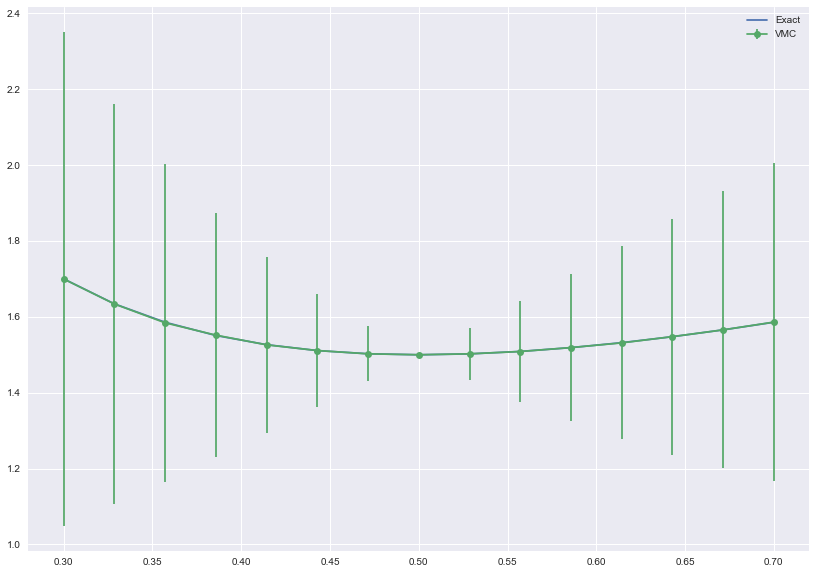

In [19]:
plt.plot(alphas.ravel(), energy_exact, label="Exact")
plt.errorbar(
    alphas.ravel(), energies_analytical, yerr=np.sqrt(variance_analytical),
    label="VMC", fmt="o-")
plt.legend(loc="best")
plt.show()